In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import src
from testingUtils import testing_main as tm
import matplotlib.pyplot as plt
import numpy as np


import src
from src.nc4.BJDSprialScan import processExpSprialScans, spiralPlotter
# import matplotlib as mp
# mpl.use('TkAgg')
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

# Testing Main Notebook

`testing_main.py` contains multiple functions:
- `main()`: choose an exp to load in, update and save it.
- `update(exp)`: update exp with new data, and display nc4.
- `check_ae(exp)`: plot last file of AE data in test.
- `check_nc4(exp)`: calc last NC4 file attributes and plot results.

----------------------TESTING EXP FILE----------------------
Test No: 23
Date: 2024-09-11
Data: ..\..\AE\Testing\24_09_11_weartest_D1.3_#1000
No. Files: AE-87 NC4-88
------------------------------------------------------------
------------------------------------------------------------
NC4 - File 87:
	Mean radius = 0.611310 mm
	Runout = 0.141 um
	Wear = -7.361 %
------------------------------------------------------------


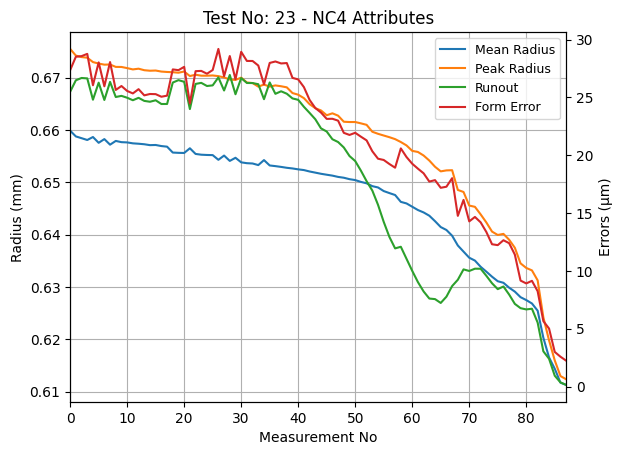

In [3]:
exp = tm.main()

In [65]:
exp.save()

------------------------------------------------------------
Updating experiemnt obj - 2024-09-12 10:27:08.399051
No. Files: AE-103 NC4-104
------------------------------------------------------------
NC4 - File 103:
	Mean radius = 0.654393 mm
	Runout = 0.154 um
	Wear = -0.832 %
------------------------------------------------------------


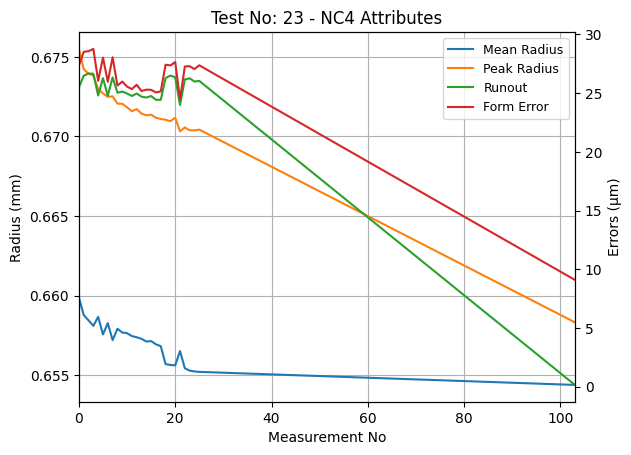

In [39]:
f = tm.update(exp)

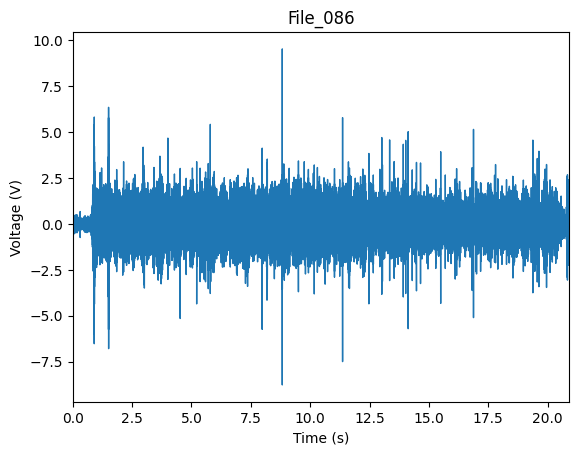

In [66]:
tm.check_ae(exp)

In [67]:
exp.nc4.process()

NC4- Calc att: 100%|██████████| 88/88 [00:08<00:00, 10.72it/s]


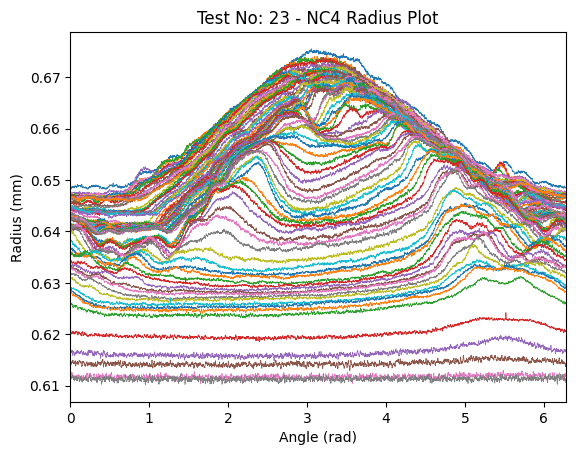

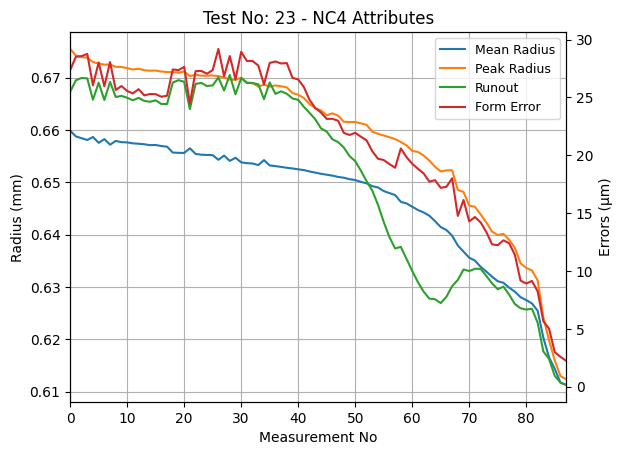

In [68]:
fno = (0, None)
f = exp.nc4.plot_xy(fno)
f = exp.nc4.plot_att(fno)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Test No: 23 - NC4 Radius Surface'}, xlabel='Angle (rad)', ylabel='Measurement Number'>)

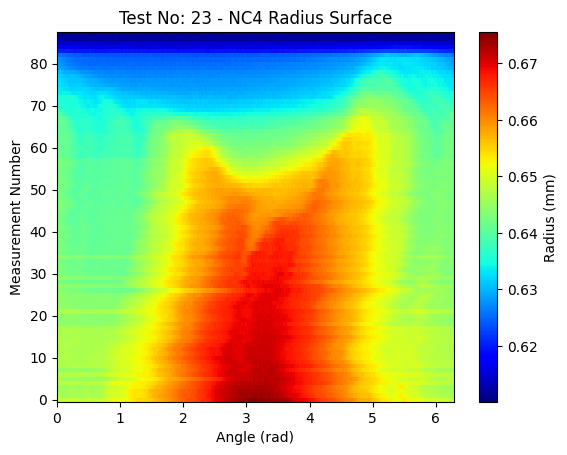

In [69]:
exp.nc4.plot_surf(fno)

In [70]:
exp.save()

In [46]:
# NC4 Spiral Scans
NOM_DIA = 1.3
FEEDRATE = 2
RPM = 60
FS = 50_000
YOFFSET = 0.03
CALFEEDRATE = 60

SCPath = CODE_DIR.joinpath(
    r'src/reference/NC4_BJD_SCurve_2024_05_30_14_17_12-Ch0-50kHz.tdms'
)
assert SCPath.exists(), "SCurve calibration file not found."

expSpiralScans = processExpSprialScans(exp,
                                       SCPath,
                                       NOM_DIA,
                                       FEEDRATE,
                                       RPM,
                                       FS,
                                       YOFFSET,
                                       CALFEEDRATE,
                                       )

for sc in expSpiralScans:
    fig, ax = sc.plotSpiralScan(saveFig=True)
    plt.close(fig)

Processing Spiral Scans: 100%|██████████| 21/21 [00:34<00:00,  1.63s/it]


In [ ]:
# %matplotlib widget
scPlotter = spiralPlotter(expSpiralScans, exp.test_info.testno).plot()

In [29]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

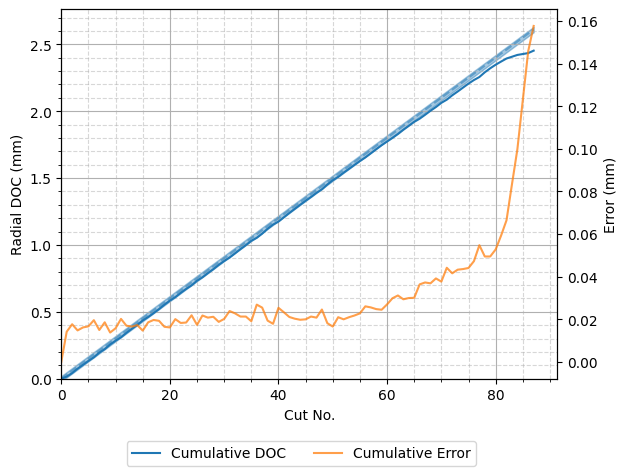

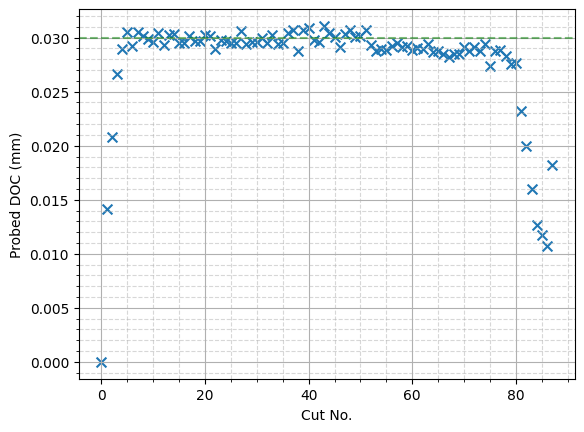

In [71]:
exp.probe
exp.probe.refreshProbeData()
if exp.probe is not None:
    fig, ax = exp.probe.plot_probe_DOC()
    ax.minorticks_on()
    ax.grid(True, which='major')
    ax.grid(True, which='minor', linestyle='--', alpha=0.5)
    # ax.set_xlim(0, len(exp.probe.probeData) - 16)

    y = exp.probe.probeData['PROBEDIFF'].values
    y = _smooth(y, win=5)

    fig, ax = plt.subplots()
    ax.scatter(x=exp.probe.probeData.index,
               y=y,
               marker='x',
               s=50,
               )
    ax.axhline(exp.probe.doc, color='g', linestyle='--', alpha=0.5)
    ax.set_xlabel('Cut No.')
    ax.set_ylabel('Probed DOC (mm)')
    ax.grid(True, which='major')
    ax.minorticks_on()
    ax.grid(True, which='minor', linestyle='--', alpha=0.5)
    # ax.set_xlim(0, len(exp.probe.probeData) - 16)

### Extra Processing - Wait till CUSP

In [4]:
exp.ae.process()

Calc FFT 1 kHz: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


In [5]:
exp.save()

In [6]:
exp.create_feat_df();

Feature DF of Test 23:
        RMS   Kurtosis  Amplitude  Skewness  Freq 10 kHz  Freq 35 kHz  \
0       NaN        NaN        NaN       NaN          NaN          NaN   
1  0.635682  12.791680  11.192291 -0.042766    14.634667    63.876165   
2  0.844497   9.419706  13.994828 -0.111183    16.194616    68.696668   
3  0.785941   7.472732   8.681134 -0.043458    16.583143    67.167170   
4  0.774868   7.200813   8.143903 -0.033251    16.554227    66.827370   

   Freq 134 kHz  Mean radius  Peak radius  Radius diff    Runout  Form error  \
0           NaN     0.659884     0.675501          NaN  0.025494    0.027365   
1     44.653742     0.658784     0.674232    -0.001100  0.026484    0.028520   
2     45.381555     0.658447     0.673943    -0.000336  0.026684    0.028574   
3     46.369666     0.658104     0.673824    -0.000343  0.026649    0.028768   
4     46.762655     0.658670     0.672988     0.000566  0.024805    0.026054   

   Avg probe  Probe diff  
0     0.0000      0.0000  
1  

In [11]:
exp.save()

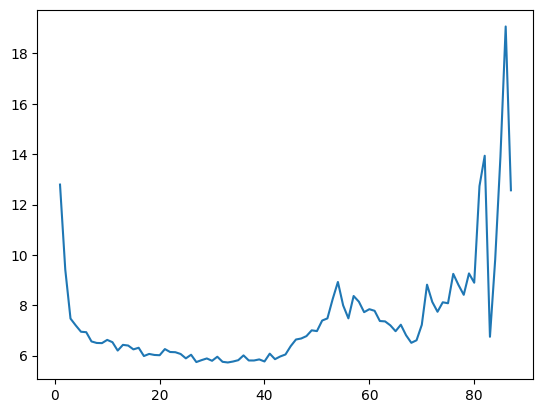

In [8]:
plt.figure()
plt.plot(exp.features['Kurtosis'])

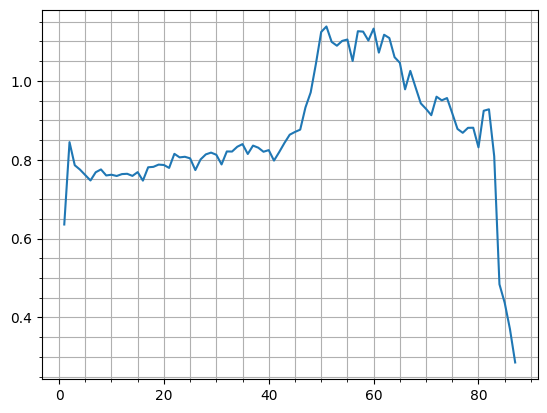

In [9]:
plt.figure()
plt.plot(exp.features['RMS'])
plt.minorticks_on()
plt.grid(True, which='both')

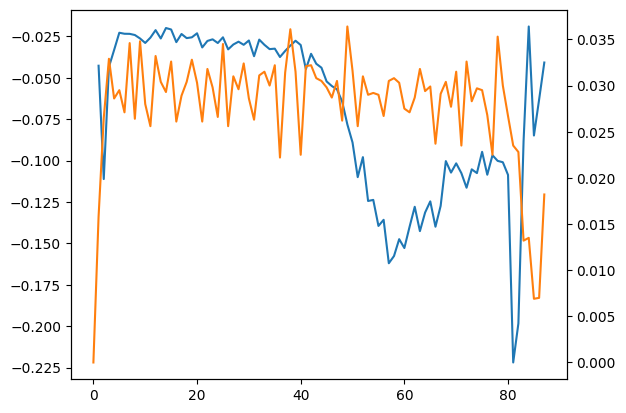

In [10]:
plt.figure()
plt.plot(exp.features['Skewness'])
# plt.ylim(2, 10)
plt.twinx()
plt.plot(exp.features['Probe diff'], 'C1')
# plt.plot(exp.features['Runout'], 'C1')

In [ ]:
nc4_df = exp.features.loc[:, ['Mean radius', 'Peak radius', 'Runout', 'Form error']]
nc4_df.head()
nc4_df.to_csv(fr'{exp.dataloc}\NC4Data.csv')